In [18]:
%%capture
# Install the necessary libraries
!pip install PyPortfolioOpt #Library to perform portfolio optimization
!pip install yfinance #Library to download financial data
!pip install forex-python #Library to download forex data

## Applying Modern Portfolio Theory on a given set of stocks using the PyPortfolioOpt library
Modern Portfolio Theory, developed by American economist Harry Markowitz, introduces the efficient frontier. The efficient frontier is the curve segment connecting the minimum variance and maximum return portfolios. Any portfolios that don't lie on this efficient frontier will be inefficient, or in other words, they sacrifice return or risk unnecessarily.¹


There are many packages or libraries available to do the optimization required in Modern Portfolio Theory. I will be using [PyPorfolioOpt](https://pypi.org/project/pyportfolioopt/)², which I found to be very flexible.

More on that later, let's get started.

### Step 1: Pick a portfolio to balance
As a starting point I have chosen the following stocks inspired by my friend's portfolio:

- Frontline (FRO.OL): NOK (listed on the Oslo Stock Exchange)
- Nordea Bank Abp (NDA-FI.HE): EUR (listed on the Helsinki Stock Exchange)
- BAWAG Group AG (BG.VI): EUR (listed on the Vienna Stock Exchange)
- CaixaBank (CABK.MC): EUR (listed on the Madrid Stock Exchange)
- Danske Bank (DANSKE.CO): DKK (listed on the Copenhagen Stock Exchange)
- McDonald’s (MCD): USD (listed on the NYSE)


### Step 2: Read in price data and adjust for exchange rates

Using yfinance, I am able to download historical adjusted close prices for all the assets. I download the exchange rates to adjust for the different currency. My friend pays taxes in Norway so I wanted to chose NOK as the base currency, but there are some errors in the exchange rate DKKNOK=X on Yahoo finance, so I'll have to stick with USD as the base currency.

In [19]:
import pandas as pd
import yfinance as yf

In [20]:
# Define the stock tickers and their respective currencies
stocks = {
    'FRO.OL': 'NOK',
    'NDA-FI.HE': 'EUR',
    'BG.VI': 'EUR',
    'CABK.MC': 'EUR',
    'DANSKE.CO': 'DKK',
    'MCD': 'USD'
}

# Download historical adjusted closing prices using yfinance for a chosen time period
stock_data = {}
for stock in stocks.keys():
    stock_data[stock] = yf.download(stock, start='2008-01-01', end='2024-09-10')['Adj Close']

# Download historical exchange rates
exchange_rates = {
    'EUR': yf.download('EURUSD=X', start='2008-01-01', end='2024-09-10')['Adj Close'],
    'NOK': yf.download('NOKUSD=X', start='2008-01-01', end='2024-09-10')['Adj Close'],
    'DKK': yf.download('DKKUSD=X', start='2008-01-01', end='2024-09-10')['Adj Close']
}

# Convert stock prices to USD
for stock, currency in stocks.items():
    if currency != 'USD':
        stock_data[stock] = stock_data[stock] * exchange_rates[currency]

# Create a dataframe of the stock prices in USD
stock_prices_usd = pd.DataFrame(stock_data)
print(stock_prices_usd.tail()) # Display the 5 latest prices for the chosen time period

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

               FRO.OL  NDA-FI.HE      BG.VI   CABK.MC  DANSKE.CO         MCD
Date                                                                        
2024-09-03  22.998578  11.748104  74.816001  5.876819  30.923552  285.519989
2024-09-04  22.599238  11.617886  75.684752  5.842642  31.163905  288.029999
2024-09-05  22.392212  11.839466  78.560425  5.954636  31.148345  287.970001
2024-09-06  22.730271  11.594445  76.777780  5.908889  30.935128  289.510010
2024-09-09  22.113380  11.735815  77.056127  6.018139  30.698184  291.290009


### Step 3: Calculate or provide expected returns

A seasoned trader might have their own, custom calculations for expected returns.
I am not seasoned nor a seer, so I will compare the available methods from PyPortfolioOpt.

The methods available for calculating expected returns are:
1. Expected returns based on the mean of historical returns
2. Exponentially weighting the mean of historical returns to emphasize recent results
3. Expected returns based on Capital Asset Pricing Model (I have used the 10 year US treasury bond giving a risk free rate of 3.65% as a benchmark)

All of these can use either geometric or arithmetic mean. I have chosen to look at geometric mean as it accounts for compounding.

In [21]:
%%capture
from pypfopt import EfficientFrontier 
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
from pypfopt import BlackLittermanModel

# Calculate expected returns and sample covariance
mu_mean = expected_returns.mean_historical_return(stock_prices_usd) # Annualized mean historical return
mu_ema = expected_returns.ema_historical_return(stock_prices_usd, span=1500) # Annualized return using exponentially weighted mean
mu_capm = expected_returns.capm_return(stock_prices_usd, risk_free_rate=0.0365) # Annualized returns calculated based on CAPM with risk free rate of 3.65%

Plotting a heatmap of annualized returns gives a better idea of what the expected returns are for each method, so we can decide which method to proceed with.

Looking at the heatmap below, it is clear that the market has been very kind for the last 1500 days (the span that I've chosen the exponentially weighted mean to be based on). I am nothing if not an optimist, so we will proceed using this expected return.

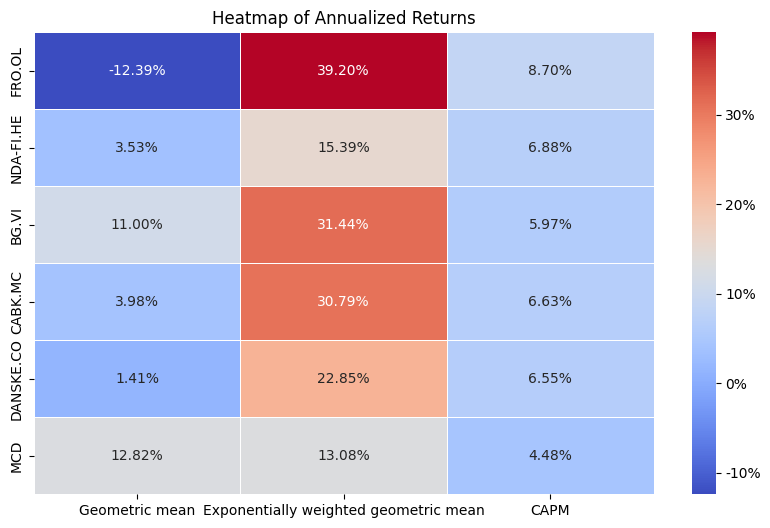

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine Series into a DataFrame
data = pd.DataFrame({
    'Geometric mean': mu_mean,
    'Exponentially weighted geometric mean': mu_ema,
    'CAPM': mu_capm
})

# Turning floats to percentages
data_percentage = data.map(lambda x: '{:.2%}'.format(x))

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data*100, annot=data_percentage, cmap='coolwarm', linewidths=.5, fmt='', cbar_kws={'format': '%.0f%%'})

plt.title('Heatmap of Annualized Returns')
plt.show()


### Step 4: Calculate portfolio variance

Picking the right risk model for calculating portfolio variance is a science in itself.
The text book option would be to use the sample covariance as the risk model.
However, the sample covariance matrix might have some instability. This can be handled by using a shrinkage estimator.
In the paper [Honey, I shrunk the sample covariance matrix](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=433840) by Ledoit and Wolf, they argue using a constant correlation model.³ This is the shrinkage estimator I will be using.

In [23]:
%%capture
# Set up the Ledoit-Wolf shrinkage estimator with constant correlation
S_LW_cc = risk_models.CovarianceShrinkage(stock_prices_usd).ledoit_wolf(shrinkage_target='constant_correlation')

### Step 5: Optimize for maximal Sharpe ratio

There are several objectives that can be chosen when it comes to Modern Portfolio Theory.
1. Minimize volatility a.k.a. playing it as safe as possible
2. Maximize return for a given risk a.k.a. you know your limits
3. Minimize risk for a given target return a.k.a. you know what you need to pay your mortgage
4. Maximize Sharpe ratio a.k.a. as much return as possible with no unnecessary risk

I know my friend is gambling man, which is why I'll be looking to maximize the Sharpe ratio.

It is also possible to add additional constraints, such as setting a maximum weight for each stock, as well as reducing zero-weights by adding penalty on small weights with a L2-regularization term.


In [24]:
# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu_ema, S_LW_cc) #Add constraints: ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.1)) #Max 10% on each weight.
# ef.add_objective(objective_functions.L2_reg, gamma=0.1) #Reduce zero-weights by adding penalty on small weights with a L2-regularization term
ef_raw_weights = ef.max_sharpe(risk_free_rate=0.0365)
ef_cleaned_weights = ef.clean_weights()
# ef.save_weights_to_file("weights_apmc_LedoitWolf.csv")  # saves to file
print(ef_cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict({'FRO.OL': 0.13954, 'NDA-FI.HE': 0.0, 'BG.VI': 0.39256, 'CABK.MC': 0.21156, 'DANSKE.CO': 0.01037, 'MCD': 0.24596})
Expected annual return: 27.8%
Annual volatility: 24.1%
Sharpe Ratio: 1.00


/home/codespace/.python/current/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


(0.2778077275519286, 0.2411532053143878, 1.0006407637723056)

### Step 6: Visualize the portfolio
The numbers above gives the weights on each stock, as well as the portfolios expected annual return, annual volatility, and Sharpe ratio.
Underneath you'll see a pie chart showing the weighted portfolio.

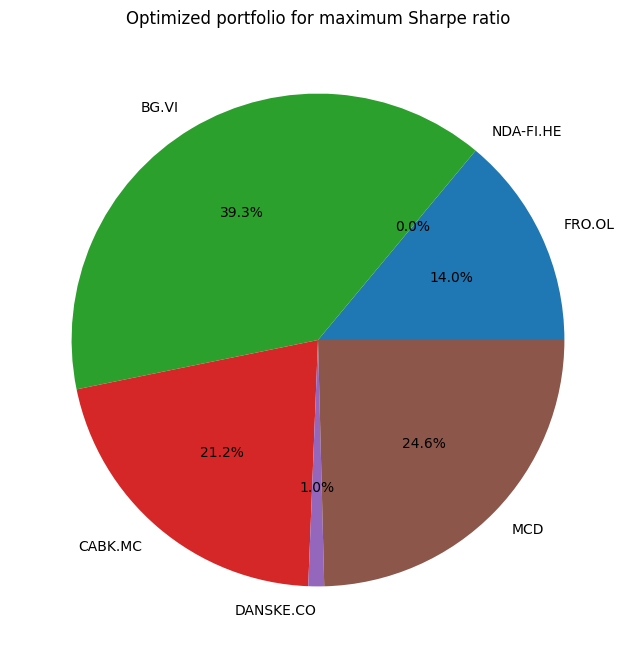

In [25]:
from collections import OrderedDict

# Extracting keys and values
labels = list(ef_cleaned_weights.keys())
sizes = list(ef_cleaned_weights.values())

# Creating the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Optimized portfolio for maximum Sharpe ratio')
plt.show()


### Bibliography
[1]    van der Wijst, Nico. Finance - A quantitative introduction. Cambridge University Press, 2013, p. 62.

[2]    Martin, R. A., (2021). PyPortfolioOpt: portfolio optimization in Python. Journal of Open Source Software, 6(61), 3066, https://doi.org/10.21105/joss.03066

[3]    Ledoit, Olivier and Wolf, Michael, Honey, I Shrunk the Sample Covariance Matrix (June 2003). UPF Economics and Business Working Paper No. 691, Available at SSRN: https://ssrn.com/abstract=433840 or http://dx.doi.org/10.2139/ssrn.433840 